# Page Detection
This code finds and crops the page out of the image

In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

sys.path.append('../src')
from ocr.helpers import implt, resize, ratio

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.0, 9.0)

### Global Variables

In [5]:
IMG = "form_digit"    # Image name/number

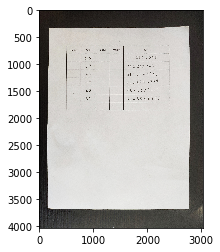

In [6]:
# Loading images and ploting it (converting to RGB from BGR)
image = cv2.cvtColor(cv2.imread("../data/form/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

In [7]:
def edges_det(img, min_val, max_val):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)

    # Applying blur and threshold
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    # Median blur replace center pixel by median of pixels under kelner
    # => removes thin details
    img = cv2.medianBlur(img, 11)

    # Add black border - detection of border touching pages
    # Contour can't touch side of image
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')

    return cv2.Canny(img, min_val, max_val)

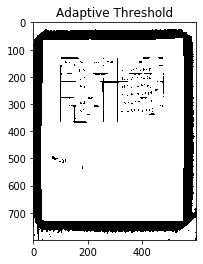

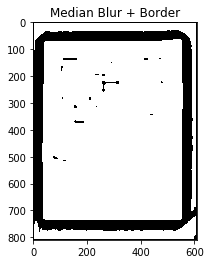

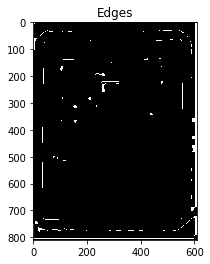

In [8]:
# Edge detection ()
edges_image = edges_det(image, 200, 250)

# Close gaps between edges (double page clouse => rectangle kernel)
edges_image = cv2.morphologyEx(edges_image, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(edges_image, 'gray', 'Edges')

In [9]:
def four_corners_sort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contour_offset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def find_page_contours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    max_area = MIN_COUNTOUR_AREA
    page_contour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                max_area < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            max_area = cv2.contourArea(approx)
            page_contour = approx[:, 0]

    # Sort corners and offset them
    page_contour = four_corners_sort(page_contour)
    return contour_offset(page_contour, (-5, -5))

PAGE CONTOUR:
[[ 38  68]
 [ 34 726]
 [547 726]
 [546  61]]


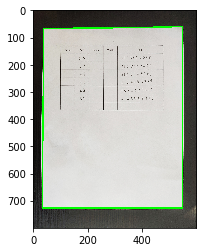

In [10]:
page_contour = find_page_contours(edges_image, resize(image))
print("PAGE CONTOUR:")
print(page_contour)
implt(cv2.drawContours(resize(image), [page_contour], -1, (0, 255, 0), 3))

       
# Recalculate to original scale
page_contour = page_contour.dot(ratio(image))

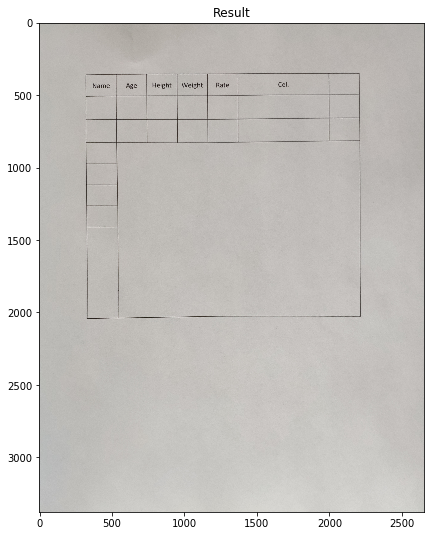

In [17]:
def persp_transform(img, s_points):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(s_points[0] - s_points[1]),
                 np.linalg.norm(s_points[2] - s_points[3]))
    width = max(np.linalg.norm(s_points[1] - s_points[2]),
                 np.linalg.norm(s_points[3] - s_points[0]))
    
    # Create target points
    t_points = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if s_points.dtype != np.float32:
        s_points = s_points.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(s_points, t_points) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = persp_transform(image, page_contour)
# img = cv2.cvtColor(newImage, cv2.COLOR_RGB2BGR)
# cv2.imwrite("../data/form/form_digit_result.jpg",img)
implt(newImage, t='Result')

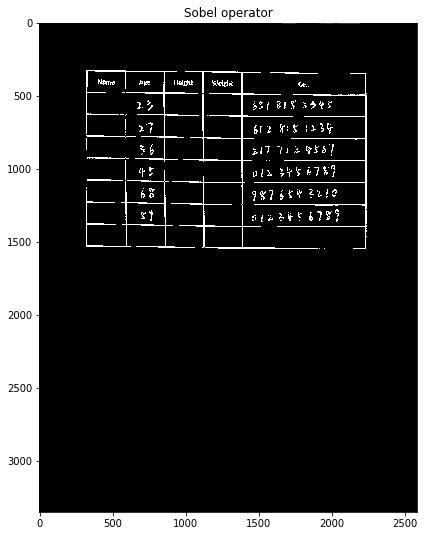

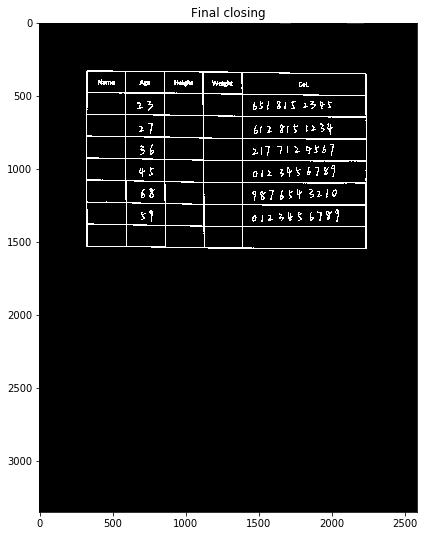

True

In [13]:
def sobel(channel):
    """ The Sobel Operator"""
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    # Combine x, y gradient magnitudes sqrt(x^2 + y^2)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return np.uint8(sobel)


def edge_detect(im):
    """ 
    Edge detection 
    The Sobel operator is applied for each image layer (RGB)
    """
    return np.max(np.array([sobel(im[:,:, 0]), sobel(im[:,:, 1]), sobel(im[:,:, 2]) ]), axis=0)

# Image pre-processing - blur, edges, threshold, closing

blurred = cv2.GaussianBlur(newImage, (3, 3), 18)
edges = edge_detect(blurred)
ret, edges = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((4,4), np.uint8))

implt(edges, 'gray', 'Sobel operator')
implt(bw_image, 'gray', 'Final closing')
cv2.imwrite("../data/form/form_digit_bw.jpg",bw_image)

In [14]:
import math

def union(a,b):
    x = min(a[0], b[0])
    y = min(a[1], b[1])
    w = max(a[0]+a[2], b[0]+b[2]) - x
    h = max(a[1]+a[3], b[1]+b[3]) - y
    return [x, y, w, h]

def intersect(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0:
        return False
    return True

def group_rectangles(rec):
    """
    Uion intersecting rectangles
    Args:
        rec - list of rectangles in form [x, y, w, h]
    Return:
        list of grouped ractangles 
    """
    tested = [False for i in range(len(rec))]
    final = []
    i = 0
    while i < len(rec):
        if not tested[i]:
            j = i+1
            while j < len(rec):
                if not tested[j] and intersect(rec[i], rec[j]):
                    rec[i] = union(rec[i], rec[j])
                    tested[j] = True
                    j = i
                j += 1
            final += [rec[i]]
        i += 1
            
    return final

def pixel_filter(img_gray):
    for i in range(img_gray.shape[0]):
        for j in range(img_gray.shape[1]):
            if (img_gray[i][j] <= 100): 
                img_gray[i][j] = 0
    return img_gray

def digit_preprocessing(digit):
    height = digit.shape[0]
    width = digit.shape[1]
    if (width <= 35):
        if (height <= 30):
            digit = cv2.resize(digit,None,fx=0.65,fy=0.65)
            i = 1
        elif (height <= 35):
            digit = cv2.resize(digit,None,fx=0.6,fy=0.6)
            i = 2
        elif (height <= 40):
            digit = cv2.resize(digit,None,fx=0.5,fy=0.5)
            i = 3
        elif (height <= 45):
            digit = cv2.resize(digit,None,fx=0.5,fy=0.5)
            i = 4
        else:
            digit = cv2.resize(digit,None,fx=0.35,fy=0.35)
            i = 9
    elif (width <= 40):
        if (height <= 30):
            digit = cv2.resize(digit,None,fx=0.65,fy=0.65)
            i = 5
        elif (height <= 35):
            digit = cv2.resize(digit,None,fx=0.6,fy=0.6)
            i = 6
        elif (height <= 40):
            digit = cv2.resize(digit,None,fx=0.55,fy=0.55)
            i = 7
        else:
            digit = cv2.resize(digit,None,fx=0.5,fy=0.5)
            i = 8
    else:
        digit = cv2.resize(digit,None,fx=0.5,fy=0.5)
        i = 8
    
    digit = 255 - digit
    
    digit = pixel_filter(digit)
    
    digit = cv2.normalize(digit,None,0,255,cv2.NORM_MINMAX)
    digit = cv2.dilate(digit, (3, 3))
    
    top = math.floor((28 - digit.shape[0])/2)
    bottom = 28 - top - digit.shape[0]
    left = math.floor((28 - digit.shape[1])/2)
    right = 28 - left - digit.shape[1]

    digit = cv2.copyMakeBorder(digit, top, bottom, left, right, cv2.BORDER_CONSTANT, value = 0)
    
    return digit, i
        
def text_detect(img, original):
    """ Text detection using contours """
    # Resize image
    small = resize(img, 2000)
    image = resize(original, 2000)
    
    # Finding contours
    mask = np.zeros(small.shape, np.uint8)
    im2, cnt, hierarchy = cv2.findContours(np.copy(small), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
#     implt(img, 'gray')
    
    # Variables for contour index and words' bounding boxes
    index = 0    
    boxes = []
    test_digits = np.array(np.zeros((1,784)))
    i = 0
    
    # CCOMP hierarchy: [Next, Previous, First Child, Parent]
    # cv2.RETR_CCOMP - contours into 2 levels
    # Go through all contours in first level
    while (index >= 0):
        x,y,w,h = cv2.boundingRect(cnt[index])
        # Get only the contour
        cv2.drawContours(mask, cnt, index, (255, 255, 255), cv2.FILLED)
        maskROI = mask[y:y+h, x:x+w]
        # Ratio of white pixels to area of bounding rectangle
        r = cv2.countNonZero(maskROI) / (w * h)
        
        # Limits for text (white pixel ratio, width, height)
        # TODO Test h/w and w/h ratios
#         if r > 0.1 and 2000 > w > 10 and 1600 > h > 10 and h/w < 3 and w/h < 10:
        if r > 0.1 and 40 > w > 1 and 1600 > h > 10 and (h/w < 3 or w/h < 10):
            boxes += [[x, y, w, h]]
            roi = image[y:y+h, x:x+w]
            
            digit = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
            
            digit, j = digit_preprocessing(digit)
            
            cv2.imwrite("../data/form/output{0}.jpg".format(i), digit)
            digit_row = np.resize(digit,(1,784))
            test_digits = np.append(test_digits,digit_row,axis=0)
            i += 1
        
        # Index of next contour
        index = hierarchy[0][index][0]
        
        
    # Group intersecting rectangles
    boxes = group_rectangles(boxes)
    bounding_boxes = np.array([0,0,0,0])
    for (x, y, w, h) in boxes:
        cv2.rectangle(image, (x, y),(x+w,y+h), (0, 255, 0), 8)
        bounding_boxes = np.vstack((bounding_boxes, np.array([x, y, x+w, y+h])))

    implt(image, t='Bounding rectangles')

    # Recalculate coordinates to original scale
    boxes = bounding_boxes.dot(ratio(image, small.shape[0])).astype(np.int64)
    
    return test_digits, boxes[1:]

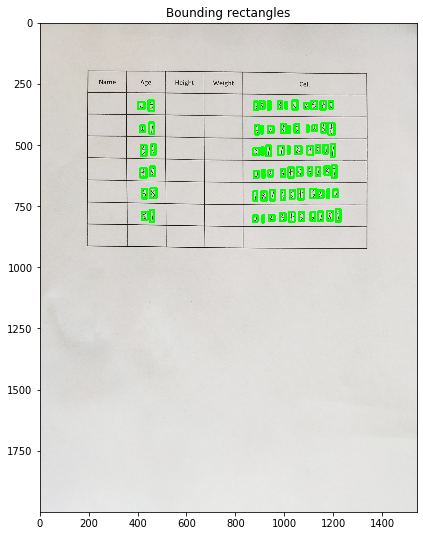

In [15]:
# Get text bounding boxes
# bw_image = cv2.cvtColor(cv2.imread("../data/pages/form_digit_bw.jpg"),cv2.COLOR_RGB2GRAY)
# newImage = cv2.imread("../data/pages/form_digit_result.jpg")
test_digits, digits_pos = text_detect(bw_image, newImage)
test_digits = np.delete(test_digits, 0, 0)
test_img = test_digits

# print("Number of boxes:", len(boxes))

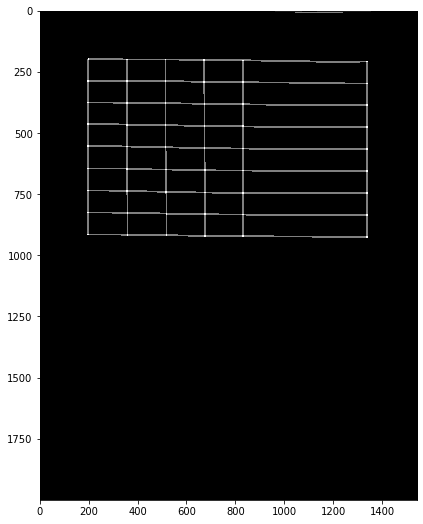

18


True

In [18]:
img = cv2.cvtColor(cv2.imread("../data/pages/form_digit_result.jpg"), cv2.COLOR_BGR2RGB)
img = resize(img, 2000)
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(img, (3, 3), 18)   # img has to be BGR
edges = edge_detect(blurred)   # create more edges
ret, edges = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)
bw_image = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((4,4), np.uint8))


# ret, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
# mask_inv = cv2.bitwise_not(mask)

horizontal = np.copy(bw_image)
vertical = np.copy(bw_image)

# [horiz]
# Specify size on horizontal axis
cols = horizontal.shape[1]
horizontal_size = cols // 15
# Create structure element for extracting horizontal lines through morphology operations
horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size, 1))
# Apply morphology operations
horizontal = cv2.erode(horizontal, horizontalStructure)
horizontal = cv2.dilate(horizontal, horizontalStructure)
# Show extracted horizontal lines
# show_wait_destroy("horizontal", horizontal)
# implt(horizontal)

rows = vertical.shape[0]
verticalsize = rows // 30   # 30 is the origin one; choose the resolution
# Create structure element for extracting vertical lines through morphology operations
verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
# Apply morphology operations
vertical = cv2.erode(vertical, verticalStructure)
vertical = cv2.dilate(vertical, verticalStructure)

# print(len(vertical[0]))
# # implt(vertical)

gray = cv2.addWeighted(horizontal,0.5,vertical,0.5,0)
# gray = cv2.addWeighted(horizontal,0.5,vertical,0.5,0)
implt(gray,'gray')
cv2.imwrite('../data/pages/separated_lines.jpg',gray)

horizontal_lines = cv2.HoughLines(horizontal,1,np.pi/180,700)  # h800
horizontal_boundary = []
print(len(horizontal_lines))
# lines = cv2.HoughLinesP(edges,1,np.pi/180,100,100,10)
for i in range(len(horizontal_lines)):
    for rho,theta in horizontal_lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
#         print(x1,x2,y1,y2)
        if (abs(y1-y2) <= 2):
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            horizontal_boundary.append(int(y1))


        
vertical_lines = cv2.HoughLines(vertical,1,np.pi/180,700)  # h800
vertical_boundary = []
# print(len(vertical_lines))
# lines = cv2.HoughLinesP(edges,1,np.pi/180,100,100,10)
for i in range(len(vertical_lines)):
    for rho,theta in vertical_lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
#         print(x1,x2,y1,y2)
        
        if (abs(x1-x2) <=2):
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            vertical_boundary.append(int(x1))
            
cv2.imwrite('../data/form/houghlines.jpg',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))


In [22]:
def mergeSort(arr): 
	if len(arr) >1: 
		mid = len(arr)//2 #Finding the mid of the array 
		L = arr[:mid] # Dividing the array elements 
		R = arr[mid:] # into 2 halves 

		mergeSort(L) # Sorting the first half 
		mergeSort(R) # Sorting the second half 

		i = j = k = 0
		
		# Copy data to temp arrays L[] and R[] 
		while i < len(L) and j < len(R): 
			if L[i] < R[j]: 
				arr[k] = L[i] 
				i+=1
			else: 
				arr[k] = R[j] 
				j+=1
			k+=1
		
		# Checking if any element was left 
		while i < len(L): 
			arr[k] = L[i] 
			i+=1
			k+=1
		
		while j < len(R): 
			arr[k] = R[j] 
			j+=1
			k+=1

def digit_to_region(box,horizontal_boundary,vertical_boundary):
    
    x = set_x(box[0],vertical_boundary)
    y = set_y(box[1],horizontal_boundary)
    
    return (x,y)

def set_x(digit_pos_x, vertical_boundary):
    
    if (digit_pos_x <= vertical_boundary[0] and digit_pos_x >= vertical_boundary[1]): # 0 is x
        x = 0
    elif (digit_pos_x <= vertical_boundary[2]):
        x = 1
    elif (digit_pos_x <= vertical_boundary[3]):
        x = 2
    elif (digit_pos_x <= vertical_boundary[4]):
        x = 3
    elif (digit_pos_x <= vertical_boundary[5]):
        x = 4
        
    return x
        
def set_y(digit_pos_y, horizontal_boundary):
    
    if (digit_pos_y <= horizontal_boundary[0] and digit_pos_y >= horizontal_boundary[1]): # 1 is x
        y = 0
    elif (digit_pos_y <= horizontal_boundary[2]):
        y = 1 
    elif (digit_pos_y <= horizontal_boundary[3]):
        y = 2
    elif (digit_pos_y <= horizontal_boundary[4]):
        y = 3
    elif (digit_pos_y <= horizontal_boundary[5]):
        y = 4
    elif (digit_pos_y <= horizontal_boundary[6]):
        y = 5
    elif (digit_pos_y <= horizontal_boundary[7]):
        y = 6
    elif (digit_pos_y <= horizontal_boundary[8]):
        y = 7
        
    return y

def sort_digits(boxes,horizontal_boundary,vertical_boundary):
    
    table = [[[] for i in range(5)]for j in range(8)]
    for index in range(boxes.shape[0]):
        box = boxes[index]
        new_x, new_y = digit_to_region(box,horizontal_boundary,vertical_boundary)
        entry = table[new_y][new_x]
        if (len(entry) == 0):
            entry.append(box.tolist()+[index])
        else:
            i = 0
            while (box[0] >= entry[i][0]):
                i += 1
                if (i == len(entry)):
                    break
            table[new_y][new_x].insert(i,box.tolist()+[index])
            
    return table
        

In [24]:
mergeSort(horizontal_boundary)
mergeSort(vertical_boundary)
new_digits = sort_digits(digits_pos,horizontal_boundary,vertical_boundary)
f=open("../data/form/labels.txt", "r")
f1 = f.readlines()
labels = eval(f1[0])
f.close()
table = [["" for i in range(5)]for j in range(8)]
for i in range(len(new_digits)):
    for j in range(len(new_digits[0])):
        if (len(new_digits[i][j]) != 0):
            num_string = ""
            for k in range(len(new_digits[i][j])):
                num_string += str(labels[new_digits[i][j][k][4]])
                
                print(labels[new_digits[i][j][k][4]], end = "")
            table[i][j] = num_string
                
            print("\n")

23

6518152345

27

6128151234

36

2177124567

45

0123456789

68

9876543210

59

0123456789



In [25]:
import csv

with open('../data/form/form.csv', 'w', newline='') as csvfile:
    fieldnames = ['Name','Age','Height','Weight','Cel.']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(1,len(table)):
        writer.writerow({'Name': table[i][0],'Age': str(table[i][1]), 'Height': str(table[i][2]),'Weight': str(table[i][3]),'Cel.': str(table[i][4])})
          